# Pre-Processing the Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle

# Load datasets
df1 = pd.read_csv("./data/student_dataset.csv")
df2 = pd.read_csv("./data/scholarship_dataset.csv")

# Merge datasets
df3 = df1.merge(df2, how='cross')

# Function to generate target variable
def generate_output(row):
    if (((row['Education_Level'],row['Scholarship_Level'])==('BS','Masters')) |
        ((row['Education_Level'],row['Scholarship_Level'])==('Masters','PhD')) |
        ((row['Education_Level'],row['Scholarship_Level'])==('PhD','PhD'))) & (row['CGPA'] >= row['Required_GPA']):
        return 1
    else:
        return 0

df3['Target'] = df3.apply(generate_output, axis=1)

# Drop unnecessary columns
df3.drop(['Name', 'Budget_Prefrence', 'Scholarship_Name', 'Scholarship_Type',
           'Scholarship_Budget','Eligible_Domain','Domain_Area',
           'Country_of_Scholarship','Country_Preference'], axis=1, inplace=True)

# Save merged dataset
df3.to_csv("combined_dataset.csv", index=False)

print(df3['Target'].value_counts())

# Load the dataset
df3 = pd.read_csv("combined_dataset.csv")

# Initialize a dictionary to store label encoders for each column
label_encoders = {}

# Apply label encoding to each categorical column separately
for col in df3.select_dtypes(include=['object']).columns:
    label_encoder = LabelEncoder()
    df3[col] = label_encoder.fit_transform(df3[col])
    label_encoders[col] = label_encoder

# Split the dataset into features (X) and target variable (y)
X = df3.drop('Target', axis=1)
y = df3['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Target
0    174982
1     75018
Name: count, dtype: int64


# Training the Model

In [2]:
X_train.head()

,CGPA,Education_Level,Required_GPA,Scholarship_Level
46108,2.83,2,2.0,2
99208,3.23,2,3.0,1
132612,2.57,0,2.0,1
172436,3.23,0,3.0,0
9907,3.23,2,2.0,1


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=2)

# Build a simple neural network model
model = Sequential([
    Dense(4, activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)),
    Dense(2, activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with a specified number of epochs
epochs = 10  # Adjust the number of epochs as needed
history = model.fit(X_train_scaled, y_train, epochs=epochs, validation_data=(X_test_scaled, y_test),callbacks=[early_stop])

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7571 - loss: 0.6220 - val_accuracy: 0.8785 - val_loss: 0.4128
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8990 - loss: 0.3908 - val_accuracy: 0.9742 - val_loss: 0.3190
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9746 - loss: 0.2966 - val_accuracy: 0.9762 - val_loss: 0.2578
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9824 - loss: 0.2454 - val_accuracy: 0.9966 - val_loss: 0.2155
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9939 - loss: 0.2089 - val_accuracy: 0.9948 - val_loss: 0.1893
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9953 - loss: 0.1851 - val_accuracy: 0.9973 - val_loss: 0.1701
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9958 - loss: 0.1668 - val_accuracy: 0.9933 - val_loss: 0.1551
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9964 - loss: 0

# Evaluating the Model

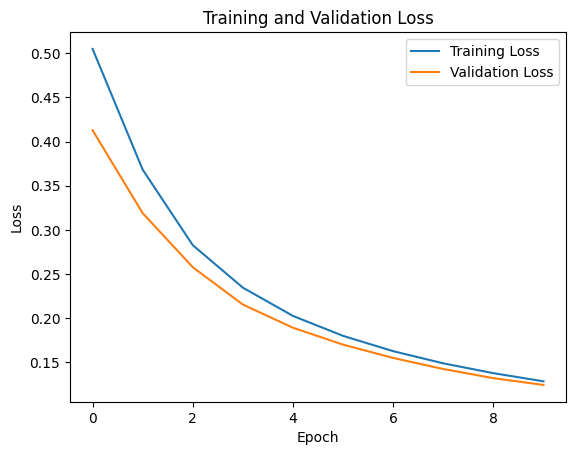

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9962 - loss: 0.1242
Accuracy: 0.9959999918937683
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     34884
           1       0.99      1.00      0.99     15116

    accuracy                           1.00     50000
   macro avg       0.99      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000

Confusion Matrix:
[[34684   200]
 [    0 15116]]


In [14]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Saving the Model

In [15]:
# Save the model
model.save("my_model.h5")

# Save label encoders to disk
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Making the Predictions

In [16]:
df3.head()

,CGPA,Education_Level,Required_GPA,Scholarship_Level,Target
0,2.53,0,3.0,1,0
1,2.53,0,2.5,2,0
2,2.53,0,3.0,1,0
3,2.53,0,3.0,2,0
4,2.53,0,3.0,0,0


In [17]:
for col, label_encoder in label_encoders.items():
    print(f"Column: {col}")
    print(list(label_encoder.classes_))
    print()

Column: Education_Level
['BS', 'Masters', 'PhD']

Column: Scholarship_Level
['BS', 'Masters', 'PhD']



In [18]:
# Load the saved model
loaded_model = load_model("my_model.h5")

# Load label encoder from disk
with open("label_encoders.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load the scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Sample raw data
raw_data = pd.DataFrame({
    'CGPA': ['3.8'],
    'Education_Level': ['BS'],
    'Required_GPA': ['3'],
    'Scholarship_Level': ['PhD'],
})

categorical_cols = ['Education_Level', 'Scholarship_Level']
numeric_cols = ['CGPA', 'Required_GPA']

# Initialize an empty DataFrame to store encoded raw data
encoded_raw_data = pd.DataFrame()

# Encode categorical features in the raw data using the loaded label encoders
for col in raw_data.columns:
    if col in label_encoder:
        label_encoder_col = label_encoder[col]
        encoded_raw_data[col] = label_encoder_col.transform(raw_data[col])
    else:
        encoded_raw_data[col] = raw_data[col]

# Scale the numerical columns
# scaled_numeric_data = scaler.transform(raw_data[numeric_cols])
scaled_numeric_data = scaler.transform(encoded_raw_data)

print(scaled_numeric_data)
# Make predictions with the loaded model
predictions = loaded_model.predict(scaled_numeric_data)

# Set the threshold
threshold = 0.5

# Apply threshold to convert probabilities to class labels
binary_predictions = (predictions > threshold).astype(int)

# Display the class labels
print("Class Labels (Predictions):")
print(binary_predictions[0][0])


[[ 1.22050912 -1.21575265  1.22871433  1.21314003]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Class Labels (Predictions):
0
